# Lab | Making predictions with logistic regression

# In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import getpass  
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.


In [3]:
query_features = '''
SELECT f.film_id, f.rental_rate,f.rating, f.length
FROM film f
LEFT JOIN film_actor fa
ON fa.film_id = f.film_id
LEFT JOIN inventory i
ON f.film_id = i.film_id 
GROUP BY film_id;'''
features = pd.read_sql_query(query_features, engine)
features

,film_id,rental_rate,rating,length
0,1,0.99,PG,86
1,2,4.99,G,48
2,3,2.99,NC-17,50
3,4,2.99,G,117
4,5,2.99,G,130
...,...,...,...,...
995,996,0.99,G,183
996,997,0.99,NC-17,179
997,998,0.99,NC-17,105
998,999,2.99,R,101


2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.


In [4]:
query_target = '''SELECT i.film_id
FROM rental r 
LEFT JOIN inventory i
ON r.inventory_id = i.inventory_id
WHERE rental_date BETWEEN '2005-05-01 00:00:01' AND '2005-5-31 23:59:59'
GROUP BY i.film_id;'''
target = pd.read_sql_query(query_target, engine)
target['Rented_May']= 1
target

,film_id,Rented_May
0,80,1
1,333,1
2,373,1
3,535,1
4,450,1
...,...,...
681,864,1
682,859,1
683,689,1
684,47,1


3. Read the data into a Pandas dataframe.


I am going to compare and put together  the target DF (rented in May)  
with the non rented so we complete a DF woth the 1000 titles on it, wether have been renetd or not.


In [5]:
#https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe
# I am creating a column where the info about rented or not is registered in a way where tell me if the film_id is 
# in one, or both DF ,so I can maniopulate the column to act like a filter, and I obtain a 1000 rows DF with all titles.

not_rented_may = features.merge(target.drop_duplicates(), on=['film_id'], 
                how='left', indicator=True)
not_rented_may


,film_id,rental_rate,rating,length,Rented_May,_merge
0,1,0.99,PG,86,1.0,both
1,2,4.99,G,48,NaN,left_only
2,3,2.99,NC-17,50,1.0,both
3,4,2.99,G,117,1.0,both
4,5,2.99,G,130,1.0,both
...,...,...,...,...,...,...
995,996,0.99,G,183,NaN,left_only
996,997,0.99,NC-17,179,NaN,left_only
997,998,0.99,NC-17,105,1.0,both
998,999,2.99,R,101,1.0,both


I select the film_ids rows that are in the 'Left' table as is the one wioth the original 100 film_ids

In [6]:
not_rented_may = not_rented_may.loc[not_rented_may['_merge'] == 'left_only']


I drop the dummy column "_merge" and I giev value '0' to the movies not rented in May

In [7]:
not_rented_may.drop(['_merge'], axis=1, inplace=True)
not_rented_may["Rented_May"]=0
not_rented_may

/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/hq/x_513gjd2qsd86w2rwvd665m0000gn/T/ipykernel_12608/3904838486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_rented_may["Rented_May"]=0


,film_id,rental_rate,rating,length,Rented_May
1,2,4.99,G,48,0
6,7,4.99,PG-13,62,0
8,9,2.99,PG-13,114,0
9,10,4.99,NC-17,63,0
12,13,4.99,PG,150,0
...,...,...,...,...,...
987,988,2.99,R,139,0
989,990,0.99,PG-13,171,0
992,993,2.99,PG-13,178,0
995,996,0.99,G,183,0


Now I have a DF of film_id not rented in May with 314 rows, and a DF of film_id that have been rented in May with 686 rows, that all together make a DF of 1000 rows (100 diff titles) indicating in the 'Rented_May' column wether if they have been rented (1) or not (0).


I select only ['film_id','Rented_May'] columns from not_rented_may so we merge just the data we need.

In [8]:
not_in_may = not_rented_may[['film_id','Rented_May']]
not_in_may 

,film_id,Rented_May
1,2,0
6,7,0
8,9,0
9,10,0
12,13,0
...,...,...
987,988,0
989,990,0
992,993,0
995,996,0


Now, I append them ignoring the indexing as the original DF follows film_id numeration for indexing, so I will reorganise this afterwards.

And I change the film_id column name to avoid confusions with the other DF. 

In [9]:
final_targ = target.append(not_in_may, ignore_index=False)

final_target = final_targ.sort_values('film_id')

final_target.columns = final_target.columns.str.replace('film_id', 'film_id_2')
final_target.reset_index(inplace=True)
final_target

,index,film_id_2,Rented_May
0,303,1,1
1,1,2,0
2,640,3,1
3,372,4,1
4,425,5,1
...,...,...,...
995,995,996,0
996,996,997,0
997,581,998,1
998,580,999,1


In [10]:
features

,film_id,rental_rate,rating,length
0,1,0.99,PG,86
1,2,4.99,G,48
2,3,2.99,NC-17,50
3,4,2.99,G,117
4,5,2.99,G,130
...,...,...,...,...
995,996,0.99,G,183
996,997,0.99,NC-17,179
997,998,0.99,NC-17,105
998,999,2.99,R,101


In [11]:
final_data = pd.concat([features,final_target], axis = 1)
final_data.drop(['film_id_2'], axis=1)
final_data


,film_id,rental_rate,rating,length,index,film_id_2,Rented_May
0,1,0.99,PG,86,303,1,1
1,2,4.99,G,48,1,2,0
2,3,2.99,NC-17,50,640,3,1
3,4,2.99,G,117,372,4,1
4,5,2.99,G,130,425,5,1
...,...,...,...,...,...,...,...
995,996,0.99,G,183,995,996,0
996,997,0.99,NC-17,179,996,997,0
997,998,0.99,NC-17,105,581,998,1
998,999,2.99,R,101,580,999,1


In [12]:
final = final_data[['film_id','rental_rate','rating','length','Rented_May']]

final

,film_id,rental_rate,rating,length,Rented_May
0,1,0.99,PG,86,1
1,2,4.99,G,48,0
2,3,2.99,NC-17,50,1
3,4,2.99,G,117,1
4,5,2.99,G,130,1
...,...,...,...,...,...
995,996,0.99,G,183,0
996,997,0.99,NC-17,179,0
997,998,0.99,NC-17,105,1
998,999,2.99,R,101,1


4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.


The only categorical left to encode is rating, as we aklready ecoded the Rented_May, as the values represent:

PG-13 = Parental guide under 13

NC-17 = Not for under 17

R     = Restricted

PG    = Parental Guide

G     = For all ages 

We could asign values (1-5) to the categoriesm, but that will asign a higher value to the 5 , and that will not be correct, so I wil ltry. OneHotEncoder


Make Binary






In [13]:
df_cat = final['rating']
unique_vals = df_cat.unique()
unique_vals

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

In [34]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder()

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final[['rating']]).toarray())

final_df_0=final.join(encoder_df)         
# I drop 'rating' as is still with the catedoty names on it and we have HotCoded in columns 1 to 5
#The columns 1 to 5 are result of the OneHotEncoder
final_df = final_df_0.drop('rating',1)
             
final_df

/var/folders/hq/x_513gjd2qsd86w2rwvd665m0000gn/T/ipykernel_12608/608419656.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  final_df = final_df_0.drop('rating',1)


,film_id,rental_rate,length,Rented_May,0,1,2,3,4
0,1,0.99,86,1,0.0,0.0,1.0,0.0,0.0
1,2,4.99,48,0,1.0,0.0,0.0,0.0,0.0
2,3,2.99,50,1,0.0,1.0,0.0,0.0,0.0
3,4,2.99,117,1,1.0,0.0,0.0,0.0,0.0
4,5,2.99,130,1,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
995,996,0.99,183,0,1.0,0.0,0.0,0.0,0.0
996,997,0.99,179,0,0.0,1.0,0.0,0.0,0.0
997,998,0.99,105,1,0.0,1.0,0.0,0.0,0.0
998,999,2.99,101,1,0.0,0.0,0.0,0.0,1.0


In [35]:
data_num = final_df[['rental_rate','length']]
data_num

,rental_rate,length
0,0.99,86
1,4.99,48
2,2.99,50
3,2.99,117
4,2.99,130
...,...,...
995,0.99,183
996,0.99,179
997,0.99,105
998,2.99,101


Let's explore the numerical columsn to see which scaler is better ( Standard or minmax)

In [36]:
data_num.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rental_rate', ylabel='Density'>

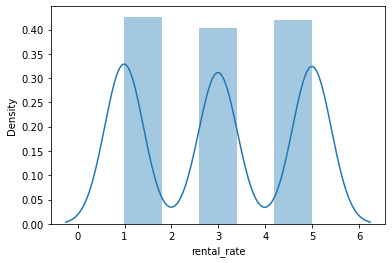

In [37]:
import seaborn as sns 

display(sns.distplot(data_num['rental_rate']))


/Users/chrislacarte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

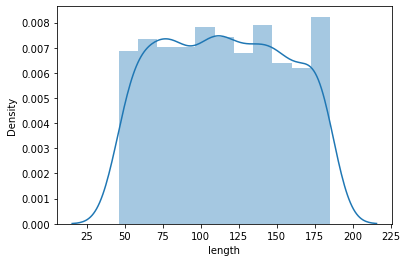

In [38]:
display(sns.distplot(data_num['length']))

They both follow a normal distribution shape and the outliers presence is not relevant so we can opt for MinMax Scaler and make the range 90,1)

In [39]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler

transformer = MinMaxScaler().fit(data_num)
#We execute the transformer we just trained: 
data_num_normalized = transformer.transform(data_num)
#transform array to DF 
w = pd.DataFrame(data_num_normalized, columns=data_num.columns)
w

,rental_rate,length
0,0.0,0.287770
1,1.0,0.014388
2,0.5,0.028777
3,0.5,0.510791
4,0.5,0.604317
...,...,...
995,0.0,0.985612
996,0.0,0.956835
997,0.0,0.424460
998,0.5,0.395683


In [40]:
final_df[['rental_rate','length']] = w[['rental_rate','length']]

final_df

,film_id,rental_rate,length,Rented_May,0,1,2,3,4
0,1,0.0,0.287770,1,0.0,0.0,1.0,0.0,0.0
1,2,1.0,0.014388,0,1.0,0.0,0.0,0.0,0.0
2,3,0.5,0.028777,1,0.0,1.0,0.0,0.0,0.0
3,4,0.5,0.510791,1,1.0,0.0,0.0,0.0,0.0
4,5,0.5,0.604317,1,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
995,996,0.0,0.985612,0,1.0,0.0,0.0,0.0,0.0
996,997,0.0,0.956835,0,0.0,1.0,0.0,0.0,0.0
997,998,0.0,0.424460,1,0.0,1.0,0.0,0.0,0.0
998,999,0.5,0.395683,1,0.0,0.0,0.0,0.0,1.0


5. Create a logistic regression model to predict this variable from the cleaned data.


X - Y split 

In [42]:
X = final_df[['rental_rate','length']]
y = final_df ["Rented_May"]

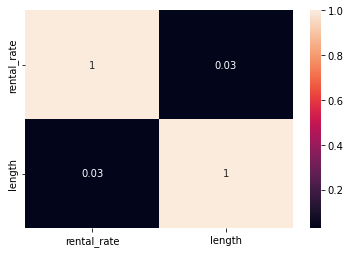

In [43]:
#Check corelati0ons:
import matplotlib.pyplot as plt
correlations_matrix = X.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [44]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [46]:
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, y_train)

LogisticRegression()

In [50]:
LR.score(X_test, y_test)

0.66

In [51]:
confusion_matrix(y_test,pred)

array([[  0,  85],
       [  0, 165]])

In [49]:
pred = LR.predict(X_test)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.66
recall:  1.0
f1:  0.7951807228915663


6. Evaluate the results.


The model is not very accurate (66%); and to be honest; I think it is because I seected not enough features as I had some difficuties with the SQL query. I reduced the number of features to just a few. 